# Custom chatbot_images_project Project

## Project Overview

**Goal**: This project demonstrates the creation of a searchable photo dataset using OpenAI's GPT models. It involves generating captions and embeddings for a collection of photos, allowing for complex queries based on the content of these images.


**Steps Overview**:

**Preparing the Dataset**

The dataset comprises approximately 60 photos. For each photo, a caption is generated along with an embedding of that caption. This allows the photos to be queried as text.

**Setup**

Import required modules such as pandas, matplotlib, and openai.
Load environment variables and API keys necessary for accessing OpenAI services.

**Creating Image Captions**

Use a custom script to generate captions for each photo in the dataset. The process involves loading photos, creating captions, and saving these captions to a CSV file.

**Generating Image Embeddings**

With the captions created, the next step involves generating embeddings for these captions using OpenAI's models. These embeddings are also saved to a CSV file for later querying.

**Custom Query Completion**

Set up a custom class and methods for querying the dataset based on the embeddings. This includes creating a prompt for OpenAI's completion models and formatting the output.

**Performance Demonstration**

Demonstrate the querying process with example questions, showcasing how the system can retrieve relevant photos based on the query.

**Conclusion and Next Steps**

Summarize the capabilities demonstrated in the notebook and outline potential future enhancements or applications.


## Setup

In [122]:
import base64
import os
import time
from typing import Tuple, List

import openai
from openai.embeddings_utils import get_embedding, distances_from_embeddings
import pandas as pd
from tqdm import tqdm
import tiktoken
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
GPT4_MODEL_NAME = "gpt-4-0125-preview"
MAX_TOKENS_AMOUNT = 128000
EXTRA_SECURITY_GAP = 100
MAX_OUTPUT_TOKENS_AMOUNT = 4096
GPT4_VISION_MODEL_NAME = "gpt-4-vision-preview"
TEXT_EMBEDDING_LARGE_MODEL = "text-embedding-3-large"


In [175]:
def load_environment_variables(file_path):
    with open(file_path, 'r') as file:
        for line in file:
            # Strip whitespace and ignore lines that are empty or start with a hash (#)
            line = line.strip()
            if line and not line.startswith('#'):
                # Split the line into key and value at the first equals sign
                key, value = line.split('=', 1)
                # Set the environment variable
                os.environ[key] = value

file_path = 'env_variables.txt'
load_environment_variables(file_path)

### Please add your OPENAI API key to 'env_variables.txt'

In [176]:
openai.api_key = os.getenv("OPENAI_API_KEY")

### Run this part in order to create image captioning:

In [ ]:
from create_image_captioning import ImageCaptionsCreator

photos_path = "resources/photos"
photos_captions_creator = ImageCaptionsCreator()
photos = photos_captions_creator.create_photos_paths(photos_path)
rows = []
for i, photo in tqdm(enumerate(photos), total=len(photos)):
    photo_name = os.path.basename(photo)
    photo_caption, gen_time, token_count = photos_captions_creator.create_image_captions(photo)
    print(f"Photo {i + 1} caption: {photo_caption}")
    rows.append([photo_name, photo_caption, gen_time, token_count])

df = pd.DataFrame(rows, columns=["Photo Name", "photo_caption", "generation_time", "completion_tokens"])

if not os.path.exists("outputs"):
    os.makedirs("outputs")

df.to_csv("outputs/photos_captions.csv", index=False)

In [ ]:
from create_image_embeddings import ImageEmbeddingsCreator

captioned_photos_path = "outputs/photos_captions.csv"
image_embeddings_creator = ImageEmbeddingsCreator(captioned_photos_path)
captioned_photos_df = image_embeddings_creator.create_image_embeddings()
captioned_photos_df.to_csv("outputs/captioned_photos_with_embeddings.csv", index=False)
print(
    f"Succesfully created image embeddings for {len(captioned_photos_df)} photos.\n Saved to outputs/captioned_photos_with_embeddings.csv.")

In [11]:
image_embeddings_path = "outputs/captioned_photos_with_embeddings.csv"
df = pd.read_csv(image_embeddings_path)
df.head()

Photo Name  \
0  WhatsApp Image 2024-01-19 at 11.37.08.jpeg   
1  WhatsApp Image 2024-01-17 at 12.55.41.jpeg   
2  WhatsApp Image 2023-11-04 at 12.24.19.jpeg   
3  WhatsApp Image 2023-12-30 at 17.03.48.jpeg   
4  WhatsApp Image 2024-02-16 at 17.34.37.jpeg   

                                       photo_caption  generation_time  \
0  The photo shows a well-maintained garden viewe...        14.887108   
1  In the photo, there are four individuals seate...        10.023257   
2  The photo shows a young child who appears to b...        10.648842   
3  The photo shows a young child standing indoors...        15.875719   
4  The photo shows two individuals, an adult and ...        10.131119   

   completion_tokens                                         embeddings  
0                286  [0.019955335184931755, 0.02967926301062107, -0...  
1                242  [-0.021634617820382118, -0.03269268199801445, ...  
2                238  [-0.03131244331598282, -0.011332199908792973, ...  
3                181  [-0.04415430128574371, 0.01735885627567768, -0...  
4                199  [-0.03840550407767296, 0.01553620770573616, -0...

## Custom Query Completion

In [8]:

SYSTEM_PROMPT = "Answer the user question as detailed as possible. In the end of your answer" \
                "provide a list of the image names you used to answer. If the image isn't " \
                "relevant for the question- ignore it" \
                "Don't include the photos names in your the answers' body, only at the end of it."

PROMPT_TEMPLATE = """
            Answer the question based on the context below, and if the question
            can't be answered based on the context, answer with an empty string.
            Provide your answer in a JSON format like so:
            
            'text' : 'The answer to the question', 
            'image_evidences': ['image1.jpg', 'image2.jpg']
                
            Context: 
        
            {}
        
            ---
        
            Question: {}
            Answer:
        """

COMPLETION_MODEL_NAME = "gpt-4-0125-preview"
MAX_TOKENS_AMOUNT = 128000
EXTRA_SECURITY_GAP = 100
MAX_OUTPUT_TOKENS_AMOUNT = 4096

In [9]:

class ImageQuery:
    def __init__(self, image_embeddings_path: str):
        self.api_key = os.getenv("OPENAI_API_KEY")
        self.image_embeddings = pd.read_csv(image_embeddings_path)

    def answer_question(self,
                        question: str,
                        top_k_context_to_use=10,
                        simple_format: bool = False
                        ) -> str:
        """
        Given a question, a dataframe containing rows of text, and a maximum
        number of desired tokens in the messages and response, return the
        answer to the question according to an OpenAI Completion model

        If the model produces an error, return an empty string
        """

        messages = self.create_prompt(question, max_token_count=MAX_TOKENS_AMOUNT,
                                      top_k_context_to_use=top_k_context_to_use,
                                      simple_format=simple_format)

        try:
            response = openai.ChatCompletion.create(
                model=COMPLETION_MODEL_NAME,
                messages=messages,
                temperature=0.2,
                max_tokens=MAX_OUTPUT_TOKENS_AMOUNT - EXTRA_SECURITY_GAP,
            )
            return response["choices"][0]["message"]['content'].strip()

        except Exception as e:
            print(e)
            return ""

    def create_prompt(self, question, max_token_count, top_k_context_to_use: int, simple_format: bool) -> List[dict]:
        """
        Given a question and a dataframe containing rows of text and their
        embeddings, return a text prompt to send to a Completion model
        """
        tokenizer = tiktoken.get_encoding("cl100k_base")
        prompt_template = PROMPT_TEMPLATE
        current_token_count = len(tokenizer.encode(prompt_template)) + \
                              len(tokenizer.encode(question))

        context = []
        for text, photo_name in \
                self.get_embedding_rows_sorted_by_relevance(question, top_k_context_to_use, simple_format)[
                    ["photo_caption", "Photo Name"]].values:
            text_token_count = len(tokenizer.encode(text))
            current_token_count += text_token_count
            if current_token_count <= max_token_count - EXTRA_SECURITY_GAP:
                context.append(f"{text}, photo_name- {photo_name}")

            else:
                break

        prompt = prompt_template.format("\n\n###\n\n".join(context), question)
        messages = [
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user", "content": prompt},
        ]
        return messages

    def get_embedding_rows_sorted_by_relevance(self, query_text: str, top_k_context_to_use: int,
                                               simple_format: bool) -> pd.DataFrame:
        df_copy = self.image_embeddings.copy()
        if simple_format:
            return df_copy

        question_embeddings = get_embedding(query_text, engine=TEXT_EMBEDDING_LARGE_MODEL)
        df_copy["embeddings"] = df_copy["embeddings"].apply(lambda x: eval(x))
        df_copy["distances"] = distances_from_embeddings(
            question_embeddings,
            df_copy["embeddings"].values,
            distance_metric="cosine"
        )
        return df_copy.sort_values("distances")[:top_k_context_to_use]

In [12]:
image_query = ImageQuery(image_embeddings_path)

## Custom Performance Demonstration

### Question 1

In [13]:
question1 = ("The majority of the pictures feature my two young children."
             "I'm interested in identifying the foods they are consuming in these photos.")

In [164]:

def show_final_answer(answer: str) -> None:
    answer = clean_output(answer)
    answer_formatted = eval(answer)
    display(answer_formatted)
    display_photos(answer_formatted["image_evidences"])
    
def clean_output(answer: str) -> str:
    return answer.replace("json","").replace("```","").replace("  ", "").replace("\n","").replace(": '",": \"").replace(".'",".\"").strip() #

def display_photos(photo_paths: List[str]) -> None:
    photo_paths = [f"resources/photos/{photo}" for photo in photo_paths]
    num_photos = len(photo_paths)
    fig, axs = plt.subplots(1, num_photos, figsize=(20, 20)) 
    
    for i, photo_path in enumerate(photo_paths):
        img = mpimg.imread(photo_path)
        axs[i].imshow(img)
        axs[i].axis('off') # Hide the axis
    
    plt.show()

In [ ]:
answer1 = image_query.answer_question(question1)

{'text': "In the photos provided, your children are seen consuming a variety of foods. These include penne pasta with a tomato-based sauce and ground meat, possibly Bolognese; remnants of a meal with sliced carrots, pieces of chicken, and possibly some rice or grains; a mix of ground meat and possibly noodles or pasta; and spaghetti bolognese. Additionally, one of the children is holding a slice of pizza from Domino's.",
 'image_evidences': ['WhatsApp Image 2024-02-18 at 18.24.21.jpeg',
  'WhatsApp Image 2023-11-01 at 14.15.54.jpeg',
  'WhatsApp Image 2023-12-14 at 12.59.01.jpeg',
  'WhatsApp Image 2024-01-03 at 18.04.33.jpeg',
  'WhatsApp Image 2023-12-30 at 17.03.48.jpeg']}

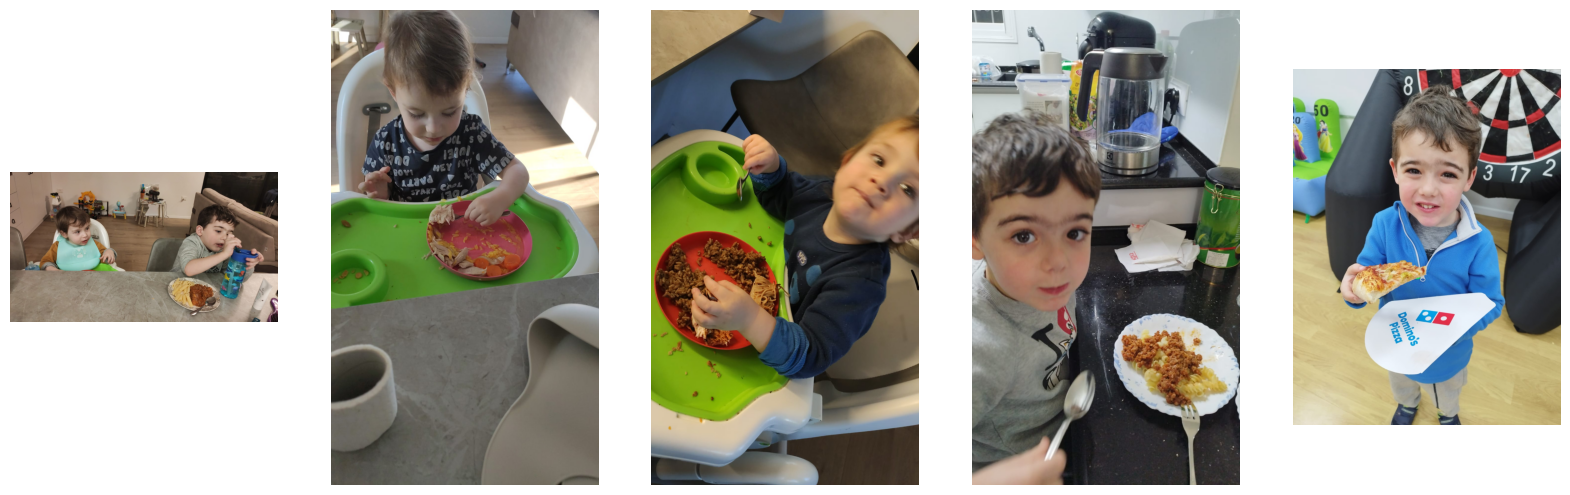

In [165]:
show_final_answer(answer1)

In [24]:
answer1_simple_prompt = image_query.answer_question(question1, simple_format=True)

{'text': "In the photos provided, your children are seen consuming or interacting with various foods. In one photo, a child is holding a slice of pizza, indicating they are eating pizza from Domino's. Another photo shows a child in a kitchen, in front of a plate with what appears to be spaghetti bolognese, a pasta dish with a tomato-based meat sauce. Additionally, there's a photo of a child sitting at a table, smiling at the camera with a joyful expression, holding a red straw in their mouth, although the specific drink or food isn't visible. Lastly, a child is seen holding a plastic fork and a yellow paper plate with a piece of white cake on it, suggesting they are eating cake. These instances highlight a variety of foods, including pizza, spaghetti bolognese, an unspecified drink, and cake.",
 'image_evidences': ['WhatsApp Image 2023-12-30 at 17.03.48.jpeg',
  'WhatsApp Image 2024-01-03 at 18.04.33.jpeg',
  'WhatsApp Image 2023-09-09 at 20.47.30.jpeg',
  'WhatsApp Image 2023-11-10 at

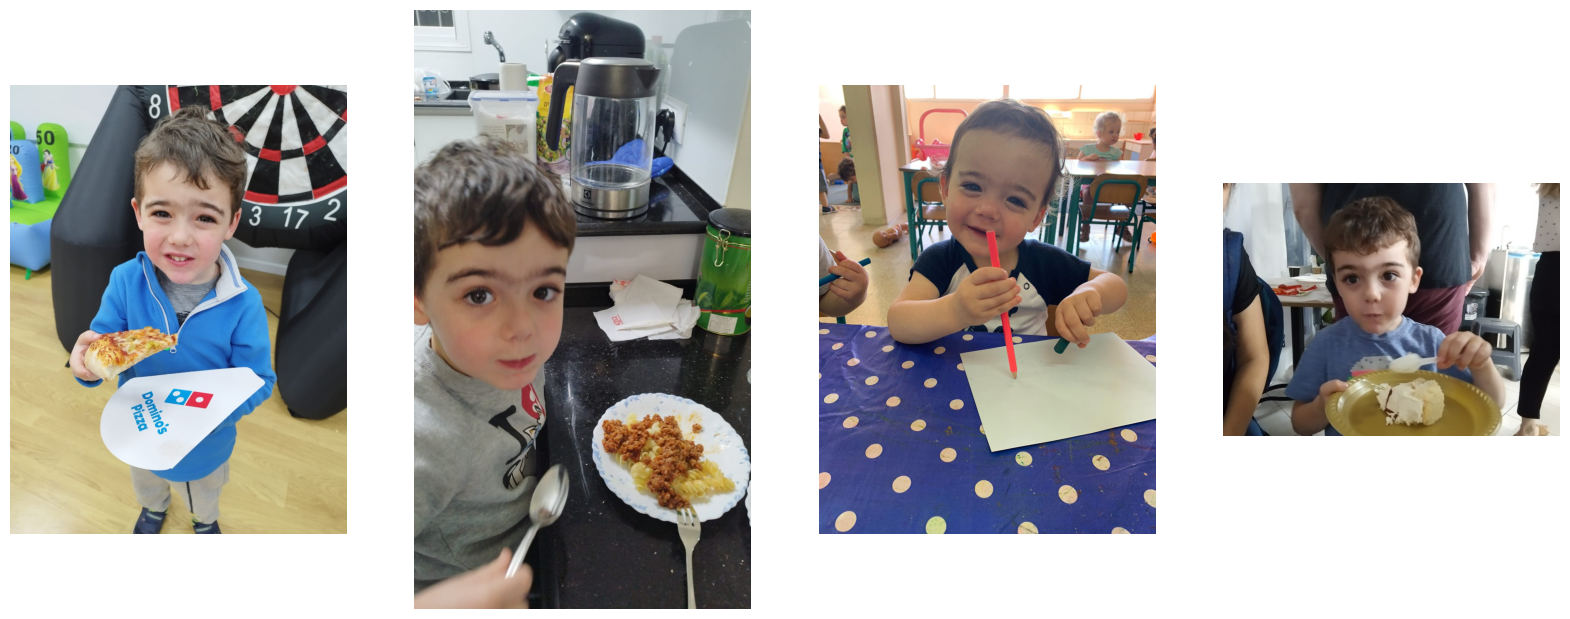

In [166]:
show_final_answer(answer1_simple_prompt)

### Q1 output conclusions
Here we can definitely see that the simple prompt yielded a single photo that is not food-related:
"There's a photo of a child sitting at a table, smiling at the camera with a joyful expression, holding a red straw in their mouth, although the specific drink or food isn't visible"

### Question 2

In [62]:
question2 = "Find all the photos with both children together. Also elaborate what activities they are doing."

In [ ]:
answer2 = image_query.answer_question(question2)

{'text': 'The photos with both children together and their activities are as follows: 1. The children are outdoors on a sunny day, sitting on a well-maintained green lawn, possibly siblings, with toys scattered around indicating they have been playing outside. 2. The children are smiling and standing in a bathroom, capturing a candid moment of childhood. 3. The children are seated at a dining table, with one in a high chair and the other drinking from a water bottle, with food on the table suggesting they are about to eat or are eating. 4. The children are outdoors on a hillside, with one looking away and the other looking towards the camera, in a setting that suggests exploration or play in a natural environment. 5. The children are playing on a colorful coin-operated ride in an indoor setting that looks like a shopping mall or an arcade, indicating a leisure and entertainment activity. 6. The children are on a city street, with the toddler pointing or reaching out with his right hand

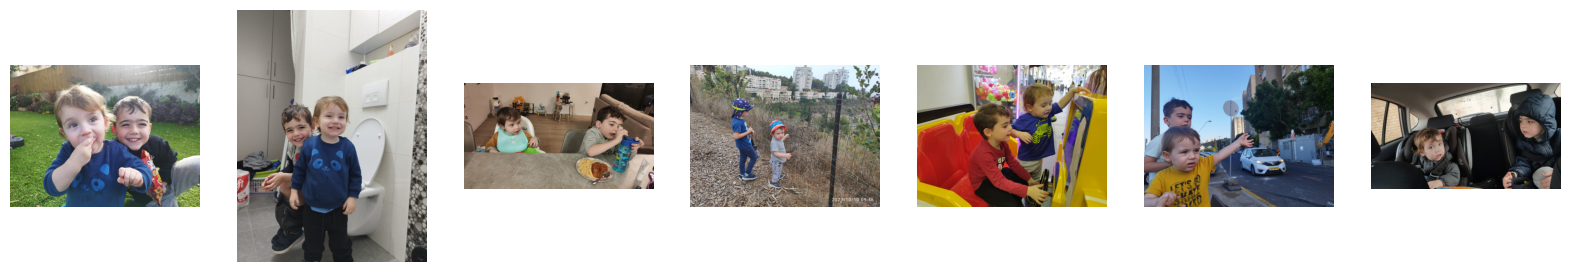

In [167]:
show_final_answer(answer2)

In [29]:
answer2_simple_prompt = image_query.answer_question(question2, simple_format=True)


{'text': "1. In the photo named 'WhatsApp Image 2023-11-18 at 12.58.42.jpeg', two young children are playing on a colorful coin-operated ride designed to resemble a vehicle. The child on the left is seated in the driver's seat, looking to the side with a smile, while the child on the right is standing next to the ride, reaching for the steering wheel. The setting looks like a shopping mall or an arcade with various amusement machines and colorful plush toys visible in the background.\n\n2. In 'WhatsApp Image 2024-01-19 at 13.19.22.jpeg', two children are outdoors on a sunny day, sitting on a well-maintained green lawn in what appears to be a private garden or backyard. The toddler in the foreground is looking directly at the camera with a finger placed in their mouth, while the older child in the background is holding a red snack packet and leaning in towards the toddler, suggesting a close and affectionate relationship, possibly siblings. There are a few toys scattered on the grass, i

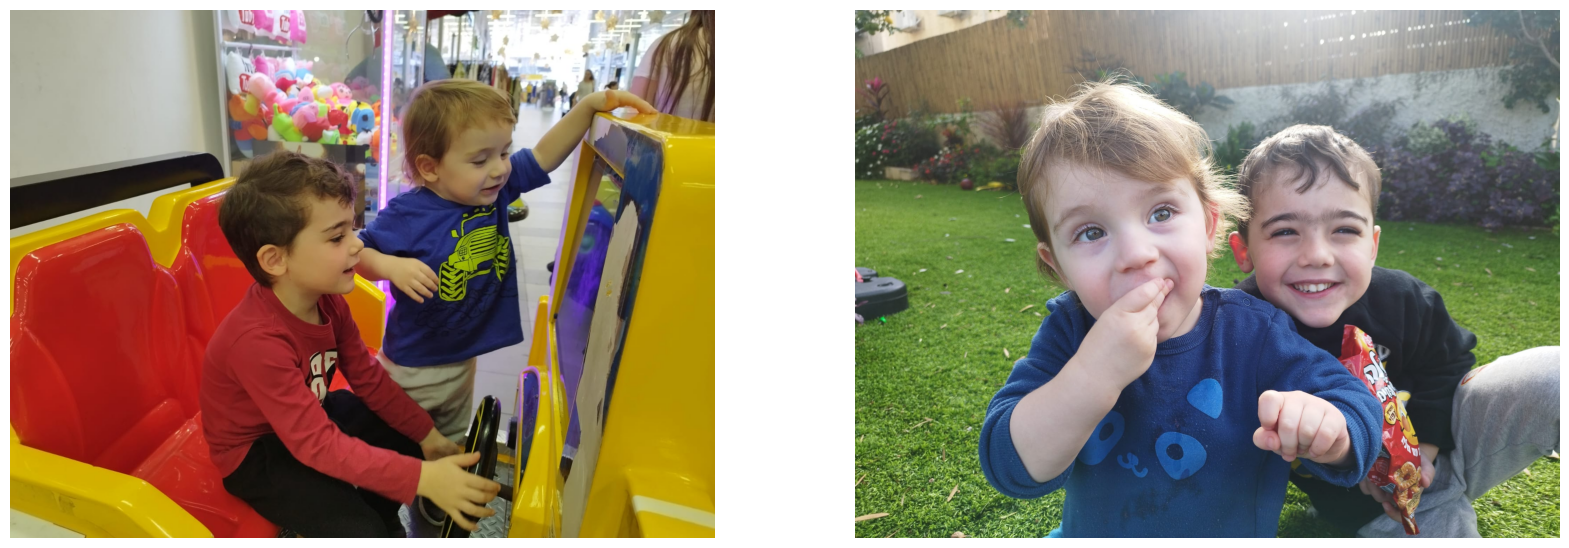

In [169]:
show_final_answer(answer2_simple_prompt)

### Q2 output conclusions
Here again we can see that the simple prompt yielded much less results with both children together.


# Conclusion:
* We demonstrated the creation of a searchable photo dataset using OpenAI's GPT models. By generating captions and embeddings for photos, 
* We enabled complex queries based on the images' content. This project opens up possibilities for efficient image retrieval systems in various applications.
* We also have seen that in our case, RAG stands out as a better method for for the task of image retrieval rather than depending solely on the longer context of the GPT model.
